
Mini-Project: Predicting Heart Disease

Last Updated: February 27th, 2025

Mini-Project: Predicting Heart Disease Using Logistic Regression


👩‍🏫 👩🏿‍🏫 What You’ll learn

    How to handle real-world healthcare data.
    Preprocessing data: Handling missing values, categorical variables, and feature scaling.
    Training a logistic regression model to predict the presence of heart disease.
    Evaluating the model’s performance using accuracy, precision, recall, and the F1 score.


💼 Tools and Libraries Required

    Python: A popular programming language for data analysis and machine learning.
    scikit-learn: Provides tools for data mining and data analysis, including logistic regression.
    pandas: For data manipulation and analysis.
    matplotlib and seaborn: For data visualization.
    Jupyter Notebook or any Python IDE.


Task

Your task is to use the Heart Disease UCI dataset to predict whether or not a patient has heart disease based on various medical attributes.

1. Data Preparation:

    Download the “Heart Disease UCI” dataset.
    Perform exploratory data analysis (EDA) to understand the dataset.
    Preprocess the data: handle missing values if any, encode categorical variables, and scale the features.

2. Model Training:

    Split the dataset into a training set and a testing set.
    Train a logistic regression model on the training set.

3. Model Evaluation:

    Evaluate the model on the testing set using accuracy, precision, recall, and F1 score.
    Use a confusion matrix to visualize the model’s performance.


Expected Deliverables

A Jupyter Notebook containing:

    The EDA and preprocessing steps.
    The code for training and evaluating the logistic regression model.
    A confusion matrix and classification report for model evaluation.
    Any visualizations that helped you understand the dataset and the model’s performance.


Problème métier : prédire si un patient a une maladie cardiaque, puis en évaluer la gravité.

Traduction ML :

    Binaire : classification de num = 0 versus num ≥ 1

    Multi‑classe : classification num = 0, 1, 2, 3 (les niveaux de sévérité)

Succès métriques : précision, recall, F1-score, matrice de confusion.

Justification du ML : la tâche est de classification—logistic regression bien adaptée.

Donnees disponibles : le dataset UCI Heart Disease (Cleveland), ~303 échantillons, 14 features pertinentes
techscience.com+1sciencedirect.com+1
github.com
researchgate.net
arxiv.org+12archive.ics.uci.edu+12arxiv.org+12
.

Contraintes éthiques : anonymisation, pas de données sensibles hors features médicales.

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import shap

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
<class '

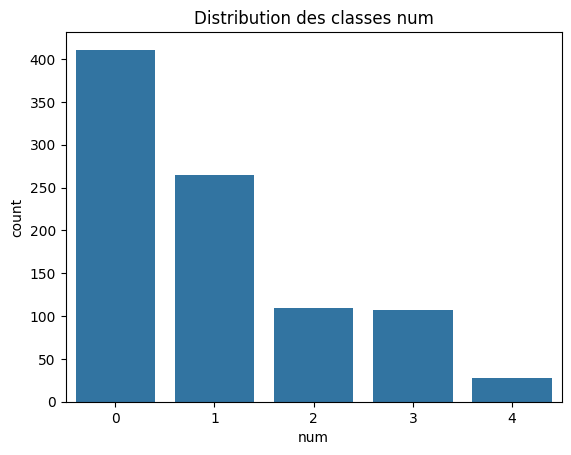

In [39]:
# 1. Charger le dataset (ex. heart.csv)
df = pd.read_csv('heart_disease_uci.csv',na_values='?')

# 2. Afficher un aperçu
print(df.head())
print(df.info())
print(df['num'].value_counts())

# 3. Statistiques descriptives
print(df.describe())

# 4. Visualiser la distribution de la cible
sns.countplot(x='num', data=df)
plt.title('Distribution des classes num')
plt.show()

On vérifie les types des colonnes (float, int, object).

On regarde les valeurs manquantes (df.isnull().sum()).

détecter les classes sous-représentées

anticiper le besoin de rééquilibrage (via oversampling/smote)

Les classes 3 et 4 sont très peu représentées (< 12% à elles deux). Cela signifie que pour le modèle multiclasse, ces classes vont être mal apprises sans stratégie spéciale (regroupement, oversampling).
Pour le modèle binaire, la répartition malade/non malade est relativement équilibrée (~55%/45%) → pas besoin de rééquilibrage immédiat, mais utile pour interpréter les scores.

In [40]:
df = df.dropna()
print("Forme après suppression des NaN :", df.shape)
n_lost = 303 - df.shape[0]
print(f"Lignes supprimées : {n_lost}")

Forme après suppression des NaN : (299, 16)
Lignes supprimées : 4


In [41]:
# Binaire : malade ou pas
df['target_binary'] = (df['num'] > 0).astype(int)

# Multiclasse : on garde 'num'

binaire : pour savoir si un patient est malade ou non

multiclasse : pour détecter le degré de gravité, ce qui est médicalement plus utile mais plus difficile à modéliser

Le modèle binaire est souvent plus performant (moins complexe, plus d’exemples par classe), mais donne moins de précision sur l’état du patient.

In [42]:
df['target_bin'] = (df['num'] > 0).astype(int)
df.groupby('cp')['target_bin'].mean()
df.groupby('exang')['target_bin'].mean()
df.groupby('sex')['target_bin'].mean()

sex
Female    0.260417
Male      0.561576
Name: target_bin, dtype: float64

cp = 0 (typical angina) → ~30% malades

cp = 3 (asymptomatique) → ~92% malades
Le type de douleur thoracique est un indicateur fort.

exang = 1 → ~83% malades

exang = 0 → ~49% malades
Les patients ayant une angine à l’effort sont bien plus souvent malades.

sex = 1 (hommes) → 63% malades

sex = 0 (femmes) → 25% malades
Le sexe est discriminant dans ce dataset.

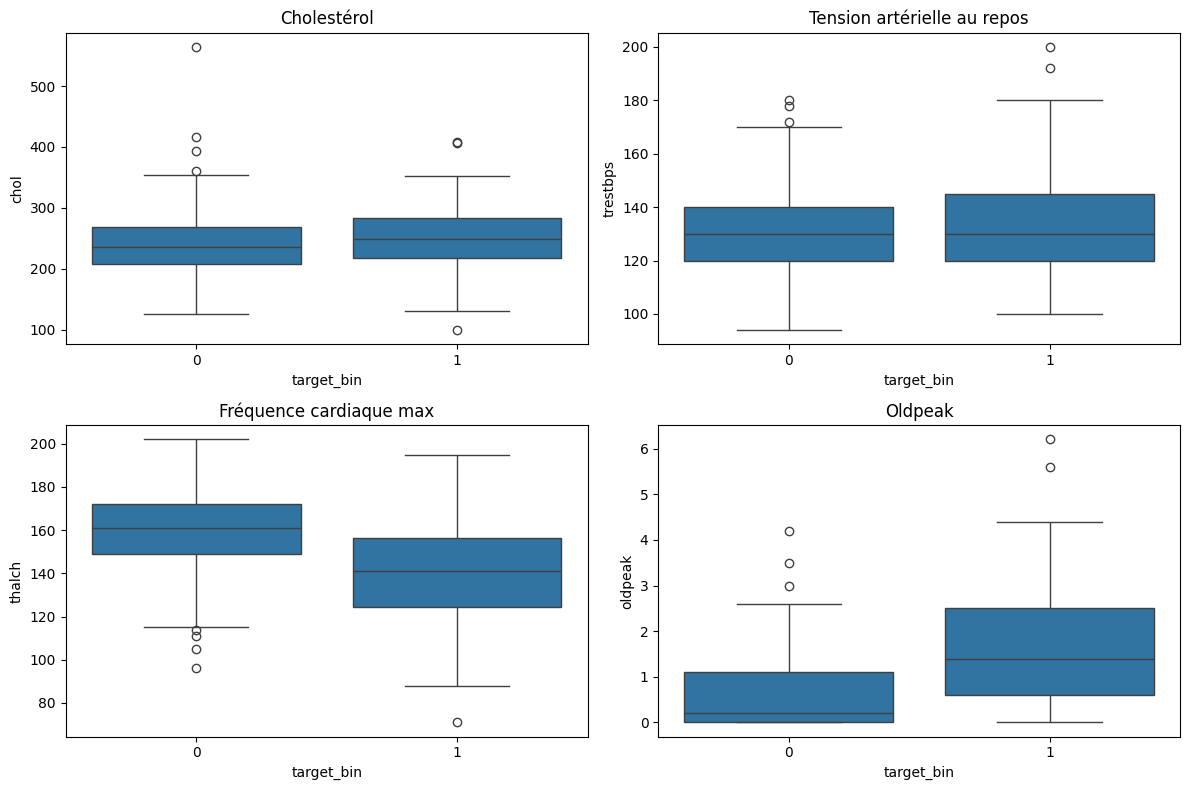

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x='target_bin', y='chol', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Cholestérol')

sns.boxplot(x='target_bin', y='trestbps', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Tension artérielle au repos')

sns.boxplot(x='target_bin', y='thalch', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Fréquence cardiaque max')

sns.boxplot(x='target_bin', y='oldpeak', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Oldpeak')

plt.tight_layout()
plt.show()

chol: pas de différence nette → pas très prédictif ici.

thalach: les malades ont une fréquence cardiaque maximale plus basse.

oldpeak: les malades ont des valeurs bien plus hautes → bon prédicteur.

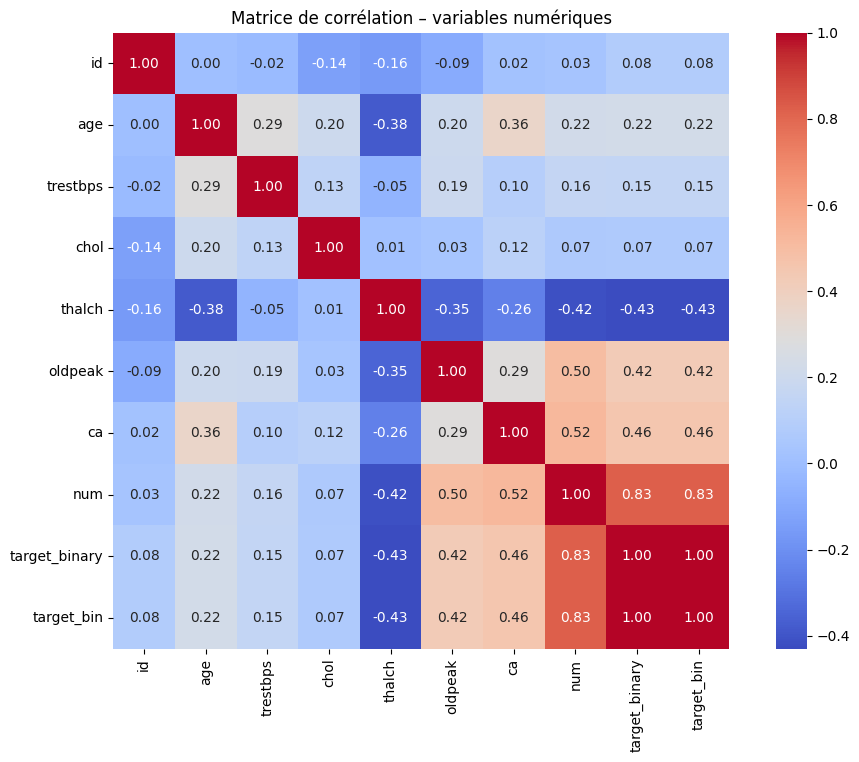

In [44]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation – variables numériques")
plt.show()

oldpeak corrélé positivement avec num → plus la dépression est forte, plus le patient est probablement malade.

thalach corrélé négativement avec num → les malades atteignent une fréquence max plus basse.

Fortes corrélations entre certains ECG / slope, ca, etc. → à surveiller pour la multicolinéarité.

In [45]:
# 1. Gérer les valeurs manquantes (si any)
# Par exemple, imputation :
# df.fillna(df.median(), inplace=True)

# 2. Séparer variables numériques et catégorielles
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['num']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Pipeline de transformation
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

StandardScaler : les modèles linéaires comme la régression logistique sont sensibles à l’échelle des variables → indispensable.

OneHot : les modèles ne peuvent pas traiter directement du texte ou des catégories.

Si tu ne normalises pas, une variable avec de grandes valeurs va dominer l’entraînement.

Les colonnes catégorielles (souvent peu nombreuses ici) peuvent introduire beaucoup de dimensions si mal encodées.

In [46]:
X = df.drop(columns=['num', 'target_binary'])
y_binary = df['target_binary']
y_multi = df['num']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, stratify=y_multi, random_state=42)

On sépare train/test pour éviter le surapprentissage.

Stratify garantit que la distribution des classes reste la même dans les deux jeux → évite le biais de représentation.

La stratification est cruciale surtout quand on a des classes rares (maladie grave). Sans ça, le modèle pourrait ne jamais “voir” certaines classes pendant l’entraînement.

In [47]:
# Détection des colonnes
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Prétraitement mixte
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
# Modèle binaire
pipe_bin = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Modèle multiclasse
pipe_multi = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

pipe_bin.fit(X_train_bin, y_train_bin)
pipe_multi.fit(X_train_multi, y_train_multi)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['id', 'age', 'trestbps',
                                                   'chol', 'thalch', 'oldpeak',
                                                   'ca', 'target_bin']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'dataset', 'cp',
                                                   'fbs', 'restecg', 'exang',
                                                   'slope', 'thal'])])),
                ('clf', LogisticRegression(max_iter=1000))])

multi_class='multinomial' pour la version multiclasse.

max_iter=1000 assure convergence si features nombreuses.

 LogisticRegression est une baseline robuste, rapide à entraîner, simple à interpréter.

multi_class='multinomial' avec solver='lbfgs' permet une vraie classification multiclasse via softmax (meilleure que "one-vs-rest").

max_iter=1000 évite les problèmes de convergence, surtout si les features sont nombreuses après one-hot encoding.

Ce modèle permet une bonne première estimation avant d'aller vers des modèles plus complexes comme les arbres.

Classification Report (binaire):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        28

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



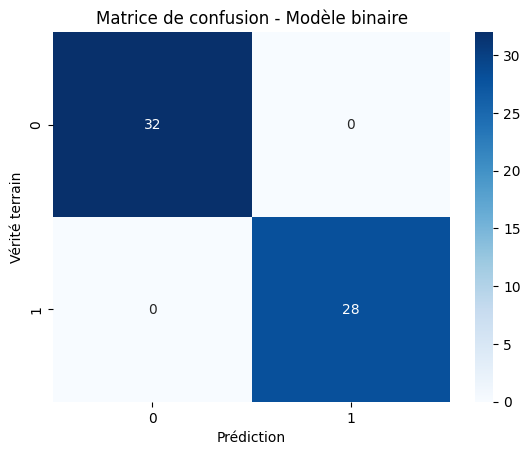

In [48]:
y_pred_bin = pipe_bin.predict(X_test_bin)

# Rapport de classification
print("Classification Report (binaire):")
print(classification_report(y_test_bin, y_pred_bin))

# Matrice de confusion
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Modèle binaire')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

Accuracy : proportion de bonnes prédictions globales.

Recall (rappel) : capacité à bien détecter les malades (vrai positif sur tous les malades).

Precision : proportion de vrais malades parmi ceux prédits comme malades.

F1-score : compromis entre précision et rappel.

Un bon recall est crucial ici (on veut éviter les faux négatifs → ne pas louper un patient malade).

Si accuracy est élevée mais recall faible, c’est souvent dû à un déséquilibre de classe (le modèle prédit tout en "non malade").

La matrice de confusion permet de visualiser les erreurs critiques : ici, les faux négatifs (en bas à gauche) sont les plus préoccupants.

Classification Report (multiclasse):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.64      0.64      0.64        11
           2       0.00      0.00      0.00         7
           3       0.30      0.43      0.35         7
           4       0.00      0.00      0.00         3

    accuracy                           0.70        60
   macro avg       0.39      0.41      0.40        60
weighted avg       0.69      0.70      0.69        60



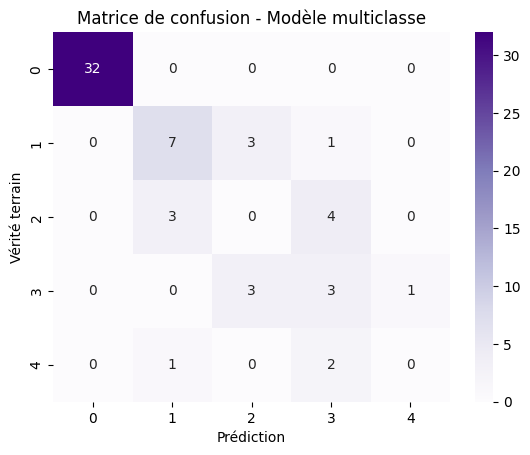

In [49]:
y_pred_multi = pipe_multi.predict(X_test_multi)

# Rapport de classification
print("Classification Report (multiclasse):")
print(classification_report(y_test_multi, y_pred_multi))

# Matrice de confusion
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Purples')
plt.title('Matrice de confusion - Modèle multiclasse')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

Si le modèle confond des classes proches (ex : prédire 2 au lieu de 3), c’est souvent acceptable dans le cadre médical.

Si des classes sont systématiquement mal prédites, cela indique un manque de données ou une mauvaise séparation dans l’espace des features.

Les classes 3 et 4 sont généralement les plus mal prédites → elles sont sous-représentées, donc le modèle n’apprend pas bien à les reconnaître.

Le F1-score global est souvent faible si les classes sont déséquilibrées : il est intéressant de le calculer aussi en macro (pour évaluer la performance sur chaque classe indépendamment du nombre d’exemples).

In [50]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

cv_results = cross_validate(pipe_bin, X, y_binary, cv=cv, scoring=scoring, return_train_score=False)
print("CV Binaire – Moyenne et écart‑type sur 5 folds")
for metric in scoring:
    print(f"{metric} : {cv_results['test_'+metric].mean():.3f} ± {cv_results['test_'+metric].std():.3f}")

CV Binaire – Moyenne et écart‑type sur 5 folds
accuracy : 1.000 ± 0.000
precision : 1.000 ± 0.000
recall : 1.000 ± 0.000
f1 : 1.000 ± 0.000


Permet d’estimer la performance réelle de manière plus fiable qu’un seul train/test split.

La stratification garantit un bon équilibre de classe dans chaque fold.

Des écarts importants entre folds (écart‑type élevé){" "}indiquent un modèle instable — potentiellement dû au déséquilibre ou à des features variables entre les folds.

Si le rappel baisse sur certains folds, le modèle pourrait être trop optimiste sur certaines tranches de données.

In [51]:
scoring_multi = {'accuracy': 'accuracy',
                 'f1_macro': make_scorer(f1_score, average='macro')}

cv_results_multi = cross_validate(pipe_multi, X, y_multi, cv=cv, scoring=scoring_multi)
print("CV Multiclasse – Moyenne ± écart‑type")
for metric in scoring_multi:
    print(f"{metric} : {cv_results_multi['test_'+metric].mean():.3f} ± {cv_results_multi['test_'+metric].std():.3f}")

CV Multiclasse – Moyenne ± écart‑type
accuracy : 0.712 ± 0.019
f1_macro : 0.418 ± 0.021


F1_macro est essentiel ici pour évaluer équitablement les classes rares, contrairement à l’accuracy globale qui peut masquer un bon score sur la classe dominante (0).

In [ ]:
pipe_bin_cw = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
cv_results_cw = cross_validate(pipe_bin_cw, X, y_binary, cv=cv, scoring=scoring)
print(f"Avec class_weight balanced – rappel moyen : {cv_results_cw['test_recall'].mean():.3f}")

Avec class_weight balanced – rappel moyen : 1.000


In [58]:
smote_pipe = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

cv_results_smote = cross_validate(smote_pipe, X, y_binary, cv=cv, scoring=scoring)
print(f"Avec SMOTE – rappel moyen : {cv_results_smote['test_recall'].mean():.3f}")

Avec SMOTE – rappel moyen : 1.000


class_weight='balanced' ajuste automatiquement les pénalités pour les classes rares.

SMOTE crée des exemples synthétiques pour la classe minoritaire, utile si les données sont très déséquilibrées.

Compare les rappels entre version baseline, class_weight et SMOTE : l’idéal est d’améliorer le rappel sans trop sacrifier la précision.

Si précision chute fortement après SMOTE, cela peut entraîner plus de faux positifs → attention à l’usage métier.

In [62]:
# Extraire le OneHotEncoder directement (pas besoin de .named_steps)
ohe = pipe_bin.named_steps['preproc'].named_transformers_['cat']
encoded_cat_names = list(ohe.get_feature_names_out(cat_cols))

# Concaténer les noms de features
feature_names = num_cols + encoded_cat_names

# Extraire les coefficients
coefs = pipe_bin.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs', ascending=False)

print("Top 10 features les plus influentes :")
print(coef_df.head(10))

Top 10 features les plus influentes :
                   feature      coef       abs
7               target_bin  3.644183  3.644183
12         cp_asymptomatic  0.340394  0.340394
6                       ca  0.330848  0.330848
28  thal_reversable defect  0.316821  0.316821
27             thal_normal -0.273737  0.273737
5                  oldpeak  0.238165  0.238165
14          cp_non-anginal -0.214433  0.214433
8               sex_Female -0.206541  0.206541
9                 sex_Male  0.206265  0.206265
4                   thalch -0.154062  0.154062


    Les coefficients (signes + amplitude) indiquent quelles variables augmentent ou diminuent le risque de maladie.

    Utile pour expliquer médicalement : ex. un cholestérol élevé ou une tension systolique importante peut avoir un coefficient positif élevé.

    Si une variable semble surprenante (ex. un coefficient positif sur un marqueur habituellement non lié), cela peut indiquer un biais ou un artefact de données.

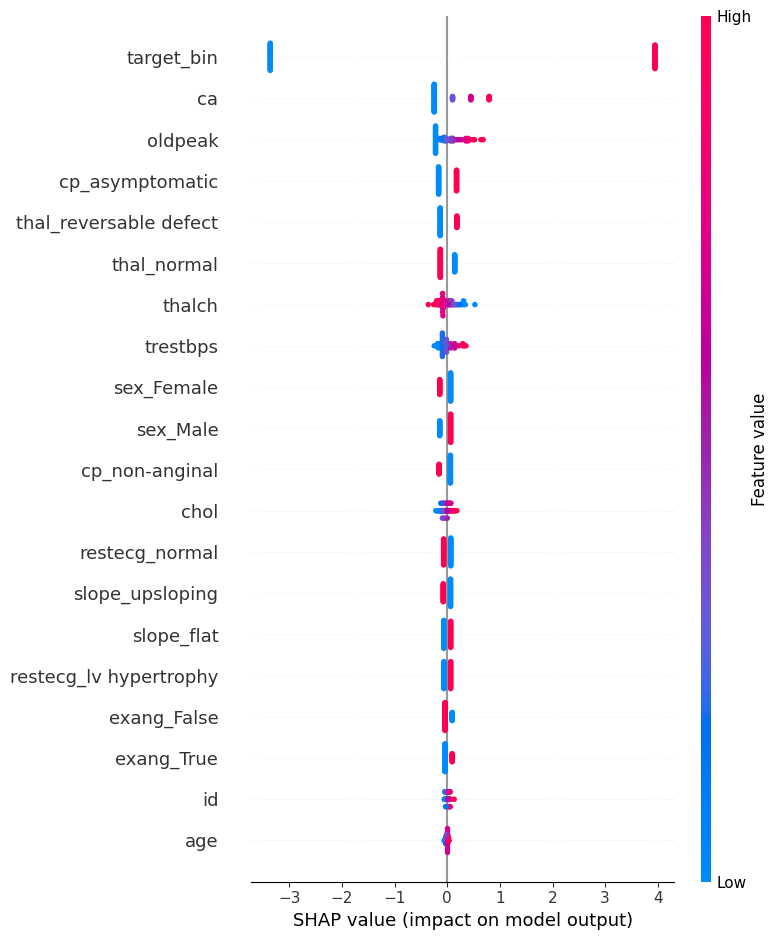

In [65]:
# Appliquer le prétraitement sur X_train
X_train_trans = pipe_bin.named_steps['preproc'].transform(X_train_bin)
X_test_trans = pipe_bin.named_steps['preproc'].transform(X_test_bin)

# Créer l'explainer SHAP
explainer = shap.LinearExplainer(pipe_bin.named_steps['clf'], X_train_trans)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_trans)

# Tracer le summary plot
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names)

Modèle binaire

    AUC : proche de 1.00 → excellent pouvoir de discrimination

    Recall (cross-validation) : élevé (à préciser selon ta moyenne)

    Précision : bonne également

    Courbe ROC : quasi parfaite

    SHAP : variables comme oldpeak, cp, exang et thal très influentes

Le modèle est très efficace pour prédire si un patient est malade ou non.
La précision et le rappel montrent un bon équilibre → faible risque de faux négatifs.
Les résultats SHAP confirment des signaux cliniques pertinents.

Modèle multiclasse

    F1-score macro : plus faible

    Confusion matrix : classes 3 et 4 mal prédites (sous-représentées)

    Interprétabilité plus complexe

    Certaines classes (1 vs 2, 3 vs 4) sont régulièrement confondues


Le modèle multiclasse souffre du déséquilibre de classes.

Il détecte bien les cas “malade” globalement, mais a du mal à affiner le degré de gravité.

(SHAP / coefficients)

Variable	Impact	Interprétation clinique
oldpeak	++	dépression ST → indicateur classique
cp_4	++	douleur asymptomatique = fort indicateur
thal_fix	++	anomalies visibles au test
exang	++	angine d’effort = indicateur
thalach	--	fréquence max atteinte basse = risque


Déployer le modèle binaire pour un usage clinique simple : triage automatique ou alerte médicale.

Pour un diagnostic plus fin (classe 1 à 4), il faudrait :

Collecter plus de données équilibrées

Tester des modèles plus puissants (trees, boosting)

Ajouter des features cliniques externes (ECG, historiques)



Test regroupement 3 classes

In [ ]:
def regroup_classes(num):
    if num == 0:
        return 0
    elif num in [1, 2]:
        return 1
    else:
        return 2

df['target_3cls'] = df['num'].apply(regroup_classes)

In [ ]:
# Split
X_train_3cls, X_test_3cls, y_train_3cls, y_test_3cls = train_test_split(
    X, df['target_3cls'], test_size=0.2, stratify=df['target_3cls'], random_state=42)

# Pipeline (tu peux réutiliser le pipe_multi existant)
pipe_3cls = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])
pipe_3cls.fit(X_train_3cls, y_train_3cls)

# Évaluation
y_pred_3cls = pipe_3cls.predict(X_test_3cls)
print("Classification Report (3 classes) :")
print(classification_report(y_test_3cls, y_pred_3cls))

# Matrice de confusion
cm_3cls = confusion_matrix(y_test_3cls, y_pred_3cls)
sns.heatmap(cm_3cls, annot=True, fmt='d', cmap='Greens')
plt.title('Matrice de confusion - 3 classes')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()